# IE MBD APR 2020: NLP Group Project (Group D)

## Topic Modelling the Quora Question Bank using LDA (Latent Dirichlet Allocation)

### Group D:

+ Alain Grullón
+ Alexandre Bouamama
+ Guillermo Germade
+ Rebecca Rosser
+ Roberto Picón
+ Tarek El Noury

In [1]:
import pandas as pd

In [2]:
# Importing the data from the Quora Questions dataset
data = pd.read_csv('This is the quora dataset.csv', encoding= 'unicode_escape')
data.columns = ['id', 'question']

In [3]:
data_text = data[['question']]
data_text['index'] = data_text.index
documents = data_text

In [3]:
data.isna().sum()

id           0
question    44
dtype: int64

In [4]:
data = data.dropna()
data.isna().sum()

id          0
question    0
dtype: int64

In [4]:
# We will work with the documents DataFrame. Here's a quick look at 5 random rows:
documents.sample(5)

,question,index
195980,What is the most effective way to learn Spanish?,195980
60848,How do I recover deleted photos from an Androi...,60848
282570,How can I see who viewed my instagram?,282570
155866,How electric field is produced by magnetic field?,155866
127223,Is it possible to prepare for IES during an MT...,127223


In [177]:
# Finding Number of missing values

documents.isna().sum()

question    44
index        0
dtype: int64

In [5]:
# And here's a look at the amount and types of data we have at our disposal:
documents.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404286 entries, 0 to 404285
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   question  404242 non-null  object
 1   index     404286 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 6.2+ MB


## Data Preparation

#### We will perform the following steps for Question Selection:



+ **Tokenization**: Split the questions into words, splitting by whitespace ' '.

+ **Question Selection**: We will observe the distribution of tokens in the questions dataset and crop off questions with relatively low amount of tokens, as they have less information for the LDA to be accurate and are also less likely to be representative of people seeking help, which is our ultimate goal for questions in our app.

+ **Null values**: We will take care of them by simply dropping them, as we do not need them since we have enough data for our purpose of finding topic clusters to categorize the Quora Questions.

In [177]:
# Finding Number of missing values

documents.isna().sum()

question    44
index        0
dtype: int64

In [6]:
# Tokenizing by splitting questions using whitespace: ' ' 
tokens = []
for doc in documents["question"].apply(str):
    tokens.append(doc.split(' '))

In [7]:
# Adding the tokens column to the DataFrame
documents["tokens"] = tokens

In [149]:
documents = documents.dropna()

In [8]:
# Adding an additional column to measure the count of tokens per question (length of lists, or count of items in lists)
documents["tokens_cnt"] = documents.tokens.apply(lambda x: len(x))

In [9]:
# Finding number of null values
documents.isna().sum()

question      44
index          0
tokens         0
tokens_cnt     0
dtype: int64

In [10]:
# Dropping the null values
documents = documents.dropna()

In [11]:
# Verifying absence of nulls
documents.isna().sum()

question      0
index         0
tokens        0
tokens_cnt    0
dtype: int64

In [12]:
# Here's the current look of the documents DF, with tokens and tokens_cnt added.
documents.sample(5)

,question,index,tokens,tokens_cnt
135977,Can u provide me with daily news?,135977,"[Can, u, provide, me, with, daily, news?]",7
202274,How do you earn money on Quora?,202274,"[How, do, you, earn, money, on, Quora?]",7
250265,Is there any limit to earn money from YouTube ...,250265,"[Is, there, any, limit, to, earn, money, from,...",12
86391,How can I know whether or not I am a genius?,86391,"[How, can, I, know, whether, or, not, I, am, a...",11
279147,How old are y'all? I just turned 45.,279147,"[How, old, are, y'all?, I, just, turned, 45.]",8


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001F5C0A62130>]],
      dtype=object)

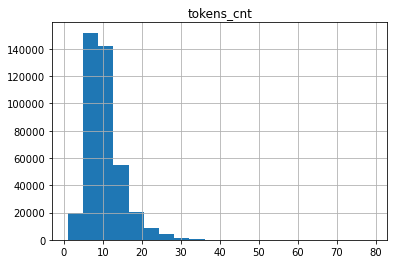

In [13]:
# We believe that questions with low token amounts are usually conveying little information, 
# and perhaps are hurtful distinguishing between good clusters of topics. So let's look at token count distribution:

binsize = 20
display(documents.hist('tokens_cnt', bins = binsize))

In [14]:
# Now looking at individual bin sizes:
display(documents.tokens_cnt.value_counts(bins=binsize).sort_index())

(0.921, 4.9]     19361
(4.9, 8.8]      151921
(8.8, 12.7]     142470
(12.7, 16.6]     55178
(16.6, 20.5]     20270
(20.5, 24.4]      8377
(24.4, 28.3]      4281
(28.3, 32.2]      1519
(32.2, 36.1]       427
(36.1, 40.0]       203
(40.0, 43.9]        96
(43.9, 47.8]        51
(47.8, 51.7]        41
(51.7, 55.6]        21
(55.6, 59.5]        12
(59.5, 63.4]         6
(63.4, 67.3]         6
(67.3, 71.2]         0
(71.2, 75.1]         1
(75.1, 79.0]         1
Name: tokens_cnt, dtype: int64

Looking at this distribution, we believe it would make sense to crop off the left tail of questions (the ones with <= 6 tokens) since they are the least helpful for our task.

Let's see how much of a percentage these tokens represent:

In [169]:
print(documents.tokens_cnt.count())
documents.tokens_cnt.value_counts(bins=20).sort_index()


404242


(0.921, 4.9]     19361
(4.9, 8.8]      151921
(8.8, 12.7]     142470
(12.7, 16.6]     55178
(16.6, 20.5]     20270
(20.5, 24.4]      8377
(24.4, 28.3]      4281
(28.3, 32.2]      1519
(32.2, 36.1]       427
(36.1, 40.0]       203
(40.0, 43.9]        96
(43.9, 47.8]        51
(47.8, 51.7]        41
(51.7, 55.6]        21
(55.6, 59.5]        12
(59.5, 63.4]         6
(63.4, 67.3]         6
(67.3, 71.2]         0
(71.2, 75.1]         1
(75.1, 79.0]         1
Name: tokens_cnt, dtype: int64

In [15]:
documents.tokens[documents.tokens_cnt <= 6].count()/documents.tokens.count()

0.1861657126176894

With ~18.6% of the dataset, we think we can drop them while retaining a satisfactory amount of data for this proof of concept.

In [16]:
#dropping the questions with <=6 tokens
documents = documents[~(documents.tokens_cnt <= 6)]

In [17]:
# resetting the DataFrame index as well as the index column
documents = documents.reset_index()
documents["index"] = documents.index

In [18]:
# Counting the remaining rows
documents.count()

level_0       328986
question      328986
index         328986
tokens        328986
tokens_cnt    328986
dtype: int64

## Data Pre-processing Functions

#### Now we will make functions that perform the following steps

+ **Tokenization**: Split the text into sentences and the sentences into words. Lowercase the words and remove punctuation. 

+ **All stopwords are removed**. Words that have 3 or fewer characters are removed as well, even if not in the gensim list of stopwords.

+ **Lemmatization**: words in third person are changed to first person and verbs in past and future tenses are changed into present.

+ **Stemmization**: words are reduced to their root form.

In [19]:
#Loading gensim and nltk libraries
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
stemmer = SnowballStemmer('english')
from nltk.stem.porter import *
import numpy as np
np.random.seed(2020)
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to C:\Users\Guillermo
[nltk_data]     Germade\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

#### Write a function to perform lemmatize and stem preprocessing steps on the data set.

In [23]:
def lemmatize_stemming(text):    
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

In [55]:
# Checking that the preprocessing is working correctly on a random sample.
# Feel free to play with the sample_index value

sample_index = 200000
doc_sample = documents.question[sample_index]

print('original document: ')    
print(doc_sample)

print('\n\n tokenized and lemmatized document: ')
print(preprocess(doc_sample))

original document: 
What is the best profession for me? I love to travel the world and I am 25 now.


 tokenized and lemmatized document: 
['best', 'profess', 'love', 'travel', 'world']


#### It worked!

#### Preprocess the questions, saving the results as ‘processed_docs’

In [54]:
processed_docs = documents['question'].apply(preprocess)
processed_docs[:10]

0    [step, step, guid, invest, share, market, india]
1                    [stori, kohinoor, noor, diamond]
2                 [increas, speed, internet, connect]
3                                [mental, lone, solv]
4                       [dissolv, water, quik, sugar]
5                   [astrolog, capricorn, moon, rise]
6                                   [good, geologist]
7                                           [instead]
8       [motorola, compani, hack, charter, motorolla]
9             [method, separ, slit, fresnel, biprism]
Name: question, dtype: object

## Bag of Words on the Data set

#### Create a dictionary from ‘processed_docs’ containing the number of times a word appears in the training set.

In [74]:
dictionary = gensim.corpora.Dictionary(processed_docs)

In [75]:
# Looking at the amount of unique tokens
print(dictionary)

Dictionary(37569 unique tokens: ['guid', 'india', 'invest', 'market', 'share']...)


In [76]:
# Looking at some of the token unique integer IDs. Feel free to play around with number_samples to see more

number_samples = 10
dict(list(dictionary.token2id.items())[:10])

{'guid': 0,
 'india': 1,
 'invest': 2,
 'market': 3,
 'share': 4,
 'step': 5,
 'diamond': 6,
 'kohinoor': 7,
 'noor': 8,
 'stori': 9}

### Gensim filter_extremes

#### Filter out tokens that appear in
+ less than 10 documents (insufficient/unreliable datapoints) or
+ more than 50% of documents (probably bad for categorizing, as they're found across many topics).


In [80]:
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

### Gensim doc2bow

+ For each document we create a dictionary reporting how many words and how many times those words appear. Save this to ‘bow_corpus’, then check our selected document earlier.

In [17]:
L =[]
for i in documents.tokens:
    L.append(type(i))

pd.Series(L).value_counts()

<class 'list'>     404198
<class 'float'>        44
dtype: int64

In [16]:

# documents["token_count"] = documents.tokens.apply(lambda x: len(x))


In [82]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
bow_corpus[100000]

[(834, 1), (1299, 1), (1668, 1), (2633, 1), (3376, 1), (4073, 1), (4880, 1)]

In [83]:
bow_doc_sample = bow_corpus[100000]
for i in range(len(bow_doc_sample)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_sample[i][0], 
                                              dictionary[bow_doc_sample[i][0]],
                                              bow_doc_sample[i][1]))

Word 834 ("control") appears 1 time.
Word 1299 ("case") appears 1 time.
Word 1668 ("loss") appears 1 time.
Word 2633 ("airbus") appears 1 time.
Word 3376 ("remain") appears 1 time.
Word 4073 ("detach") appears 1 time.
Word 4880 ("vertic") appears 1 time.


## TF-IDF

+ Create tf-idf model object using models.TfidfModel on ‘bow_corpus’ and save it to ‘tfidf’, then apply transformation to the entire corpus and call it ‘corpus_tfidf’. Finally we preview TF-IDF scores for our first document.

In [86]:
from gensim import corpora, models

tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

from pprint import pprint

for doc in corpus_tfidf:
    pprint(doc)
    
    break

[(0, 0.42689670967641136),
 (1, 0.18518456364563315),
 (2, 0.3019869755675633),
 (3, 0.2819330679993177),
 (4, 0.33782668106587427),
 (5, 0.7061562305686286)]


## Running LDA using Bag of Words

+ Train our lda model using gensim.models.LdaMulticore and save it to ‘lda_model’

In [87]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=5, id2word=dictionary, passes=2, workers=2)

For each topic, we will explore the words occuring in that topic and its relative weight.

In [88]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.017*"think" + 0.015*"note" + 0.014*"trump" + 0.014*"peopl" + 0.013*"indian" + 0.012*"lose" + 0.012*"happen" + 0.010*"india" + 0.010*"presid" + 0.009*"weight"
Topic: 1 
Words: 0.073*"best" + 0.034*"india" + 0.025*"learn" + 0.016*"money" + 0.015*"onlin" + 0.013*"program" + 0.012*"phone" + 0.012*"account" + 0.012*"movi" + 0.011*"number"
Topic: 2 
Words: 0.026*"best" + 0.015*"time" + 0.014*"english" + 0.012*"good" + 0.012*"place" + 0.009*"word" + 0.009*"instagram" + 0.009*"iphon" + 0.009*"card" + 0.008*"differ"
Topic: 3 
Words: 0.030*"differ" + 0.026*"quora" + 0.021*"thing" + 0.021*"know" + 0.021*"life" + 0.020*"question" + 0.019*"peopl" + 0.014*"girl" + 0.012*"love" + 0.012*"need"
Topic: 4 
Words: 0.037*"like" + 0.017*"engin" + 0.016*"book" + 0.014*"world" + 0.012*"univers" + 0.012*"best" + 0.011*"prepar" + 0.010*"year" + 0.010*"good" + 0.009*"student"


## Running LDA using TF-IDF

In [90]:
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=5, id2word=dictionary, passes=2, workers=4)

for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.017*"money" + 0.011*"trump" + 0.011*"best" + 0.010*"note" + 0.010*"lose" + 0.009*"think" + 0.009*"india" + 0.009*"weight" + 0.008*"donald" + 0.008*"presid"
Topic: 1 Word: 0.023*"quora" + 0.016*"question" + 0.014*"movi" + 0.014*"best" + 0.010*"peopl" + 0.010*"answer" + 0.008*"facebook" + 0.008*"account" + 0.008*"instagram" + 0.007*"watch"
Topic: 2 Word: 0.013*"engin" + 0.010*"best" + 0.007*"studi" + 0.006*"android" + 0.006*"card" + 0.006*"student" + 0.005*"colleg" + 0.005*"good" + 0.005*"youtub" + 0.005*"scienc"
Topic: 3 Word: 0.017*"know" + 0.016*"thing" + 0.015*"life" + 0.013*"like" + 0.012*"love" + 0.010*"girl" + 0.009*"best" + 0.009*"mean" + 0.007*"market" + 0.007*"feel"
Topic: 4 Word: 0.014*"learn" + 0.013*"best" + 0.013*"differ" + 0.011*"improv" + 0.010*"program" + 0.010*"languag" + 0.009*"english" + 0.008*"websit" + 0.008*"busi" + 0.007*"start"


In [ ]:
val = 6145 #Change to whatever you want
print("The original question is: <<", documents.iloc[val,0], ">>")
print()
print("The preprocessed document is:", processed_docs[val])


In [ ]:
for index, score in sorted(lda_model[bow_corpus[6126]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model.print_topic(index, 10)))

In [ ]:
for index, score in sorted(lda_model_tfidf[bow_corpus[4310]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model_tfidf.print_topic(index, 10)))